# **Model evaluation**

In [2]:
import xarray as xr, numpy as np, pandas as pd, matplotlib.pyplot as plt, geopandas as gpd
import cartopy, matplotlib, regionmask, re, glob

from matplotlib.patches import Rectangle

# set range of data we want to plot
lons = slice(-85,-65); lats = slice(25,50)

# define projection to be used throughout
proj = cartopy.crs.PlateCarree()

## **Spatial pattern**

In [5]:
# list all the files we want to include
fl = glob.glob("data/pr_NAM-44_*.nc")

In [34]:
len(fl)

10

In [9]:
# load shapefile to show study region
sf = gpd.read_file("sf_studyregion/")

# load ERA5 data & compute climatology
era5 = xr.open_dataset("data/era5_tp_daily_na_extended_-85--65E_25-50N_su.nc").tp
era5 = era5.resample(time = "AS-JAN").sum().sel(time = slice("1980", "2020")).mean("time")   # annual climatology, 1980-2020

Text(0.5, 0.9, 'Spatial pattern of annual precipitation in ERA5 & CORDEX')

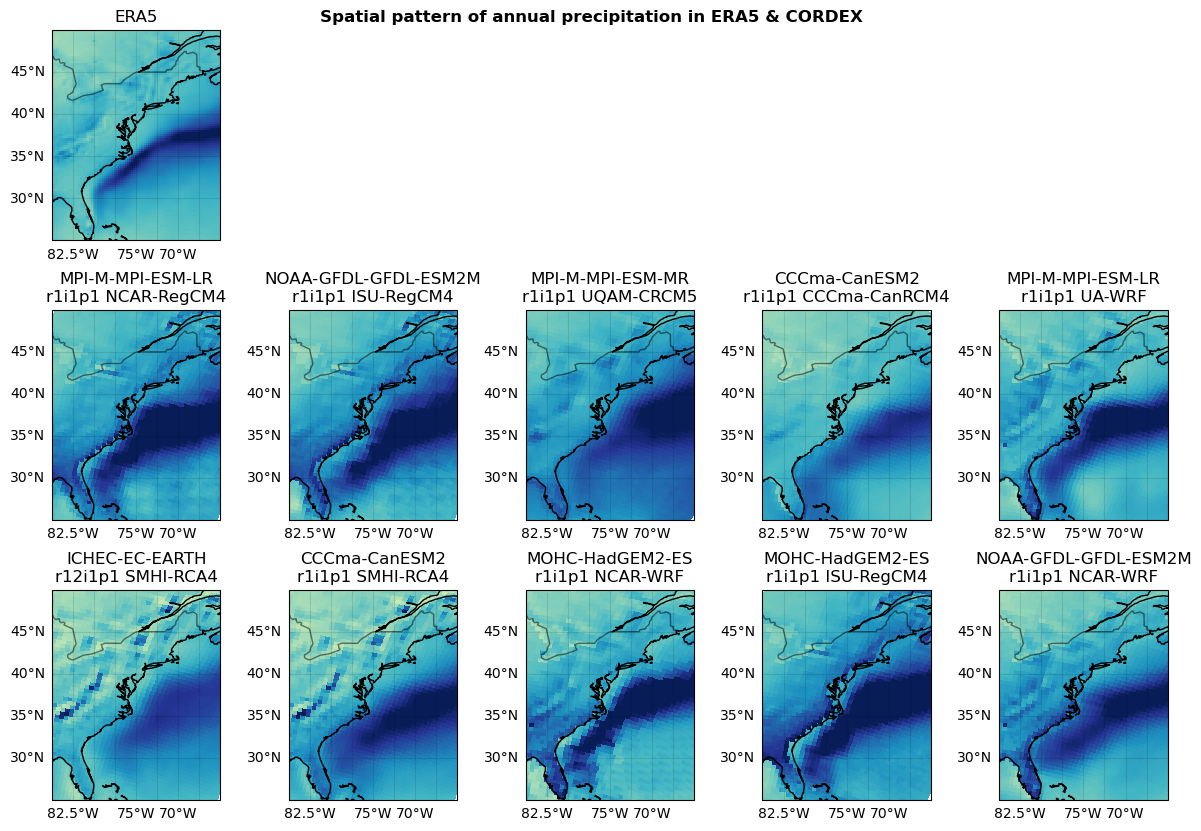

In [32]:
fig, axs = plt.subplots(ncols = 5, nrows = 3, figsize = (15, 10), dpi = 100, subplot_kw = {"projection" : proj,  "extent" : (lons.start, lons.stop, lats.start, lats.stop)}, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.1, hspace = 0.33)
plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "vmax" : 2500}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ERA5

ax = axs[0,0]
era5.plot(ax = ax, **plot_kwargs, add_colorbar = False)
ax.set_title("ERA5")

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

for ax in axs[0,1:]: ax.set_axis_off()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Models

for i in range(len(fl)):
    ax = fig.axes[5+i]
    
    da = xr.open_dataset(fl[i]).pr.resample(time = "AS-JAN").sum().sel(time = slice("1980", "2020")).mean("time")
    ax.pcolormesh(da.lon, da.lat, da, **plot_kwargs)
    
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])
    
    ax.set_title(fl[i].split("_")[2]+"\n" + " ".join(fl[i].split("_")[4:6]))
    
plt.suptitle("Spatial pattern of annual precipitation in ERA5 & CORDEX", fontweight = "bold", y = 0.9)

In [26]:
# example of line breaking
print("some text\nsome more text")

In [27]:
fl[i].split("_")

['data/pr',
 'NAM-44',
 'MPI-M-MPI-ESM-LR',
 'rcp85',
 'r1i1p1',
 'NCAR-RegCM4',
 'v4-4-rc8',
 'day',
 'sp.nc']

## **Seasonal cycle**

In [39]:
# list all the files we want to include
fl = glob.glob("data/pr_NAM-44_*.nc")

# load shapefile to extract time series over study region
sf = gpd.read_file("sf_studyregion/")

# load ERA5 data & compute seasonal cycle
era5 = xr.open_dataset("data/era5_tp_daily_na_extended_-85--65E_25-50N_su.nc").tp
rm_era5 = regionmask.mask_3D_geopandas(sf, era5.lon, era5.lat).squeeze(drop = True)
era5 = era5.where(rm_era5 == 1).mean(["lon", "lat"]).sel(time = slice("1980", "2020"))
era5 = era5.groupby("time.dayofyear").mean()

# define axis labels for DOY plotting
days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 1]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

Text(0.5, 1, 'Seasonal cycle of precipitation over study region in ERA5 (black) & CORDEX (blue)')

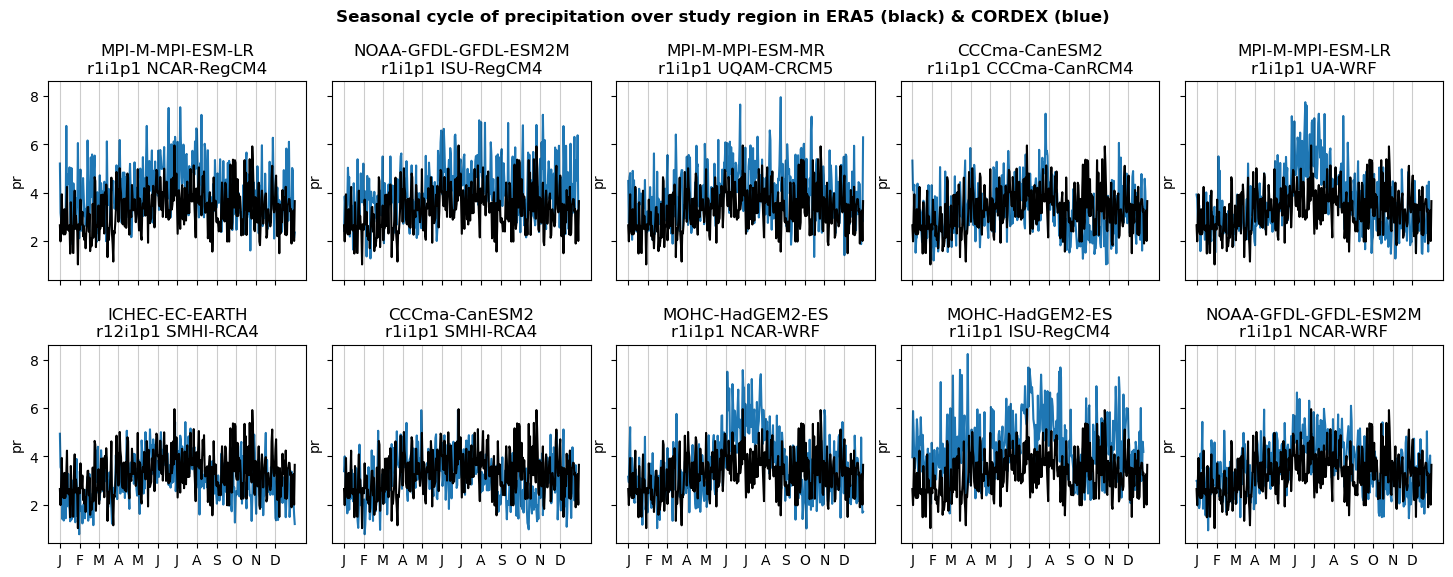

In [40]:
fig, axs = plt.subplots(ncols = 5, nrows = 2, figsize = (18, 6), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.1, hspace = 0.33)

for i in range(10):
    ax = fig.axes[i]
    
    era5.plot(ax = ax, color = "k")
    
    da = xr.open_dataset(fl[i]).pr.sel(time = slice("1980", "2020"))
    rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True)
    
    if "rlat" in da.dims:
        xydims = ["rlat", "rlon"]
    else:
        xydims = ["x", "y"]
        
    ts = da.where(rm == 1).mean(xydims).groupby("time.dayofyear").mean()
    
    ts.plot(ax = ax, color = "tab:blue", zorder = -10)
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    ax.grid(axis = "x", color = "k", alpha = 0.2)
    ax.set_xlabel("")

    ax.set_title(fl[i].split("_")[2]+"\n" + " ".join(fl[i].split("_")[4:6]))
    
plt.suptitle("Seasonal cycle of precipitation over study region in ERA5 (black) & CORDEX (blue)", fontweight = "bold", y = 1)


### **Scaled seasonal cycle**

Text(0.5, 1, 'Seasonal cycle of precipitation over study region in ERA5 (black) & CORDEX (blue)')

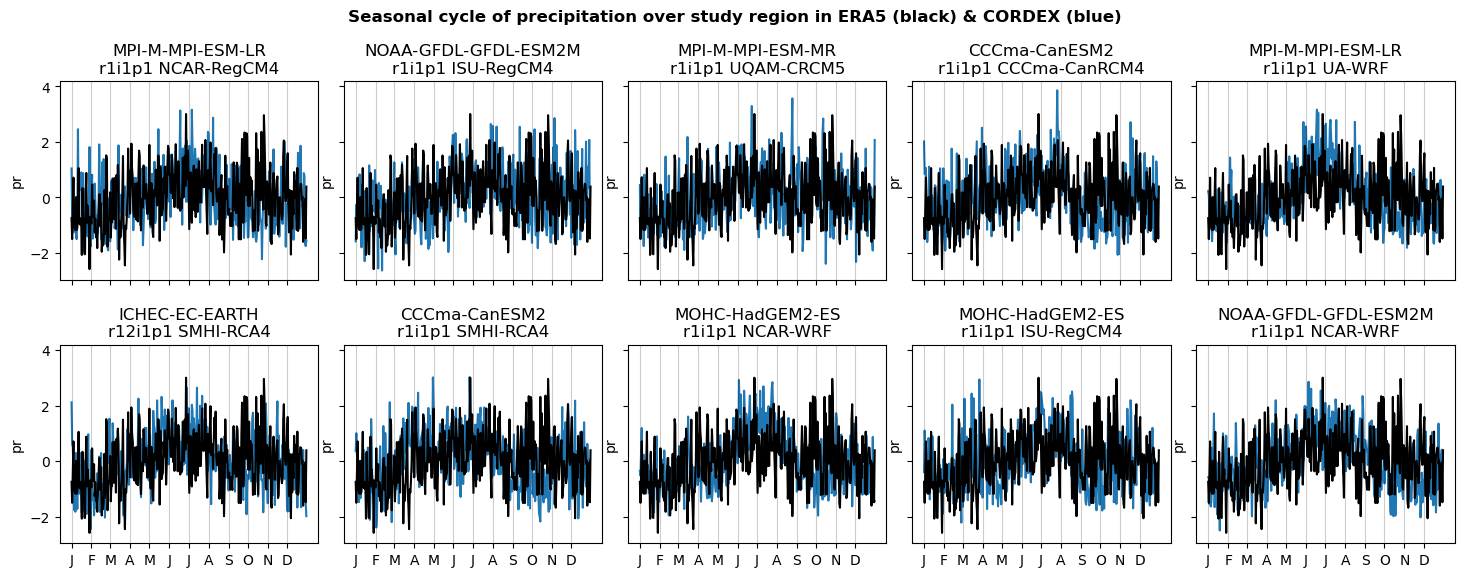

In [41]:
def scale(ts): return (ts - ts.mean()) / ts.std()

fig, axs = plt.subplots(ncols = 5, nrows = 2, figsize = (18, 6), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.1, hspace = 0.33)

for i in range(10):
    ax = fig.axes[i]
    
    scale(era5).plot(ax = ax, color = "k")
    
    da = xr.open_dataset(fl[i]).pr.sel(time = slice("1980", "2020"))
    rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True)
    
    if "rlat" in da.dims:
        xydims = ["rlat", "rlon"]
    else:
        xydims = ["x", "y"]
        
    ts = da.where(rm ==1).mean(xydims).groupby("time.dayofyear").mean()
    scale(ts).plot(ax = ax, color = "tab:blue", zorder = -10)
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    ax.grid(axis = "x", color = "k", alpha = 0.2)
    ax.set_xlabel("")

    ax.set_title(fl[i].split("_")[2]+"\n" + " ".join(fl[i].split("_")[4:6]))
    
plt.suptitle("Seasonal cycle of precipitation over study region in ERA5 (black) & CORDEX (blue)", fontweight = "bold", y = 1)


## **Time series for climate explorer**

In [99]:
# compute time series - specify number of days to aggregate
ndays = 1

# list all the files we want to include
fl = glob.glob("data/pr_NAM-44_*.nc")

for fnm in fl:
    
    da = xr.open_dataset(fnm).pr
        
    if "rlat" in da.dims:
        xydims = ["rlat", "rlon"]
    else:
        xydims = ["x", "y"]
        
    rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True)
    pr_ts = da.where(rm ==1).mean(xydims)
    
    cx_ts = pr_ts.rolling(time = ndays).sum().groupby("time.season")["JJA"].resample(time = "AS-JAN").max()
        
    # specify filename
    mdl = "_".join(fnm.split("_")[1:3] + fnm.split("_")[4:6])
    csv_fnm = "ny-flooding_rx1day_"+mdl+".dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: rx1day - "+mdl+" New York flooding 2023, c.barnes22@imperial.ac.uk"
    str2 = "# rx1day [mm/day] annual maximum of 1-day accumulated precipitation over NE USA at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year rx1day"

    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    cx_ts.assign_coords(time = cx_ts.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

! Filename too long:  ny-flooding_rx1day_NAM-44_NOAA-GFDL-GFDL-ESM2M_r1i1p1_ISU-RegCM4.dat
! Filename too long:  ny-flooding_rx1day_NAM-44_NOAA-GFDL-GFDL-ESM2M_r1i1p1_NCAR-WRF.dat


---
# **Exporting data to netcdf for upload to Climate Explorer**


## **Single time series**

In [6]:
# load data & create annual timeseries
pr_1max = xr.open_dataset("data/era5_tp_daily_na_extended_-85--65E_25-50N_su.nc").tp.mean(["lat", "lon"]).resample(time = "AS-JAN").max()

# sort out time dimension for Climate Explorer compatibility
y0 = pr_1max.time.dt.year.min()
pr_1max = pr_1max.assign_coords(time = pr_1max.time.dt.year - y0)
pr_1max["time"] = pr_1max.time.assign_attrs(standard_name = "time",
                                  units = "years since 1950-1-1 12:00:00",
                                  calendar = "proleptic_gregorian",
                                  axis = "T")
# sort out encoding of missing values
pr_1max.encoding["_FillValue"] = -3e+33
pr_1max.encoding["missing_value"] = -3e+33

pr_1max.to_netcdf("test-data-for-cx.nc")

## **Ensemble data**
_Example only, data not provided_

In [ ]:
# load all time series & cat into a single DataArray
ds = xr.concat([pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["time", varnm], index_col = 0).to_xarray().expand_dims(ens = [fnm[-13:-8]]) for fnm in sorted(glob.glob("ts/*"+varnm+"_NAM-44*"))], 
               "ens")[varnm]

# sort out time dimension for Climate Explorer compatibility - note that these are already YEARLY TIME SERIES
y0 = ds.time.min()
ds = ds.assign_coords(time = ds.time - y0)
ds["time"] = ds.time.assign_attrs(standard_name = "time",
                                  units = "years since "+str(y0.values.tolist())+"-1-1 12:00:00",
                                  calendar = "proleptic_gregorian",
                                  axis = "T")

# sort out ensemble index for CX compatibility
ds = ds.assign_coords(ens = [float(v) for v in range(len(ds.ens.values))])
ds["ens"] = ds.ens.assign_attrs(axis = "X")

# reorder dimensions
ds = ds.transpose("time", "ens").copy()
ds.encoding["coordinates"] = "ens time"

# sort out encoding of missing values
ds.encoding["_FillValue"] = -3e+33
ds.encoding["missing_value"] = -3e+33

# and save
ds.to_netcdf("ts/canada-wildfires_"+varnm+"_CanESM2-CanRCM2.nc")

# save as a single dataframe as well, for easier R processing
reduce(lambda  left, right: pd.merge(left,right,left_index = True, right_index = True, how = 'outer'),
       [pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["year", fnm[-13:-8]],
                    index_col = 0) for fnm in sorted(glob.glob("ts/*"+varnm+"_NAM-44*"))]).to_csv("ts/canada-wildfires_"+varnm+"_CanESM2-CanRCM2.csv")